In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

print(tf.__version__)

2.10.0


In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.head()

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [5]:
data_tweets = pd.read_csv("../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [6]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [7]:
data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


In [8]:
# Combine all 4 datasets
#data = pd.concat([data_news_headlines,data_tweets,data_sitcoms,data_reddit], ignore_index=True)
# Combine 3 datasets
data = pd.concat([data_news_headlines,data_tweets,data_sitcoms], ignore_index=True)

# remove non string (nan) rows
for index, row in data.iterrows():
    if not type(row['text']) == str:
        data = data.drop(index, axis='index')

# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,label
0,"20 years after big tobacco, is it time for 'bi...",0.0
1,newlywed britney spears hangs bloody sheet in ...,1.0
2,"trump administration points to new york, chica...",0.0
3,impossible to tell if frazzled woman in walgre...,1.0
4,samantha bee tells democrats what it'll take t...,0.0


In [9]:
data_sitcoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1202 entries, 5 to 6040
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    1202 non-null   object 
 1   label   1202 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.2+ KB


Set dataset and training variables

In [10]:
subset_size = 800 ##was 1400
testing_size = int(subset_size * 0.4)
validation_size = int(subset_size * 0.2)
shuffle_size = subset_size - validation_size

data_batch_size = 2 ##was32

In [11]:
data = data_sitcoms.sample(frac=1).reset_index(drop=True) ##was just data
train_data = data_sitcoms.head(subset_size) ##was just data
test_data = data_sitcoms.tail(testing_size) ##was just data

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][validation_size:], 
        train_data['label'][validation_size:]
    )
).shuffle(shuffle_size).batch(data_batch_size)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][:validation_size],
        train_data['label'][:validation_size]
    )
).batch(data_batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
        test_data['text'],
        test_data['label']
    )
)

Set training variables

In [13]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

## Download Preprocessing and Encoding Model Layers from TensorflowHub
## https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1 original model from Nathan
## https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2 smaller model, less accurate
## https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2 more layers, smallest hidden layers, less accurate

In [14]:
preprocessing_layer = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3', 
    name='preprocessing'
)

bert_encoder = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4', 
    trainable=True, 
    name='BERT_encoder'
)

Create the model using, the BERT encoder

In [15]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessing_layer(text_input)
    outputs = bert_encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

Sanity check of model (untrained result)

In [16]:

text_test = ["Please, keep talking. I always yawn when I am interested."]
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.4390473]], shape=(1, 1), dtype=float32)


In [17]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Set loss function

In [18]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

Create the optimizer

In [19]:
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

Compile the model

In [20]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Train the model

In [21]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/10
320/320 [==============================] - 81s 226ms/step - loss: 0.7268 - binary_accuracy: 0.4859 - val_loss: 0.6950 - val_binary_accuracy: 0.5437
Epoch 2/10
320/320 [==============================] - 72s 226ms/step - loss: 0.7196 - binary_accuracy: 0.6344 - val_loss: 1.0848 - val_binary_accuracy: 0.6125
Epoch 3/10
320/320 [==============================] - 72s 224ms/step - loss: 0.3980 - binary_accuracy: 0.9047 - val_loss: 2.5983 - val_binary_accuracy: 0.5312
Epoch 4/10
320/320 [==============================] - 71s 223ms/step - loss: 0.0856 - binary_accuracy: 0.9828 - val_loss: 2.2562 - val_binary_accuracy: 0.6812
Epoch 5/10
320/320 [==============================] - 71s 223ms/step - loss: 0.0078 - binary_accuracy: 0.9953 - val_loss: 2.9599 - val_binary_accuracy: 0.6750
Epoch 6/10
320/320 [==============================] - 72s 224ms/step - loss: 0.0106 - binary_accuracy: 0.9984 - val_loss: 2.9969 - val_binary_accuracy: 0.6875
Epoch 7/10
320/320 [==========================

Test the model

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Plot the accuracy and loss over time

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


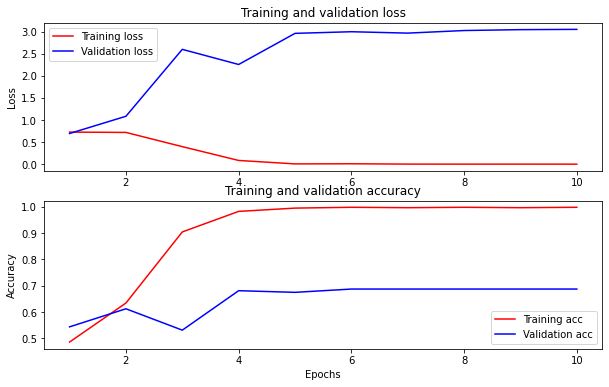

In [22]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Export for inference

In [23]:
saved_model_path = './model_saves/bert_v1/'
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_saves/bert_v1/assets


INFO:tensorflow:Assets written to: ./model_saves/bert_v1/assets


Reload and test inference

In [24]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [25]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: ', inputs[i], ' : score: ', results.numpy()[i][0], ' : rounded: ', round(results.numpy()[i][0]))
  print()


examples = [
    "Please, keep talking. I always yawn when I am interested.", # expect 1
    "Well, what a surprise.", # expect 1
    "Really, Sherlock? No! You are clever.", # expect 1
    "The quick brown fox jumps over the lazy dog", # expect 0
    "Numerous references to the phrase have occurred in movies, television, and books." # expect 0
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.99999785  : rounded:  1
input:  Well, what a surprise.  : score:  0.9999976  : rounded:  1
input:  Really, Sherlock? No! You are clever.  : score:  0.99999714  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.9999957  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.9999962  : rounded:  1

Results from the model in memory:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.0001488497  : rounded:  0
input:  Well, what a surprise.  : score:  3.417701e-05  : rounded:  0
input:  Really, Sherlock? No! You are clever.  : score:  0.9999981  : rounded:  1
input:  The quick brown fox jumps over the lazy dog  : score:  0.9999702  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.404422  : rounded:  